In [2]:
"""\
# Copyright (C) 2023 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 --version

# From Google Colab
#!git clone https://github.com/jesusBV20/multi_C3BF.git
#!rsync -a multi_C3BF/ .
#!rm -r multi_C3BF

Python 3.11.2


In [3]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import os
import numpy as np
from numpy import linalg as LA
import warnings

# Para graficar
import matplotlib.pyplot as plt
from seaborn import color_palette

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# QP solvers
#!pip install qpsolvers
#from qpsolvers import solve_qp

# ----------------------------------------------------------------------
# CBF_tools
# ----------------------------------------------------------------------

# Toolbox
from simulations.utils.toolbox import unicycle_patch, fmt_data_axis, cone_params, createDir

# GVF + CBF simulator
from simulations.utils.simulator import simulator

# GVF trajectories
from simulations.gvf_traj.gvf_traj_ellipse  import gvf_ellipse, draw

E = np.array([[0, 1],[-1, 0]])

## Drawing rho candidates

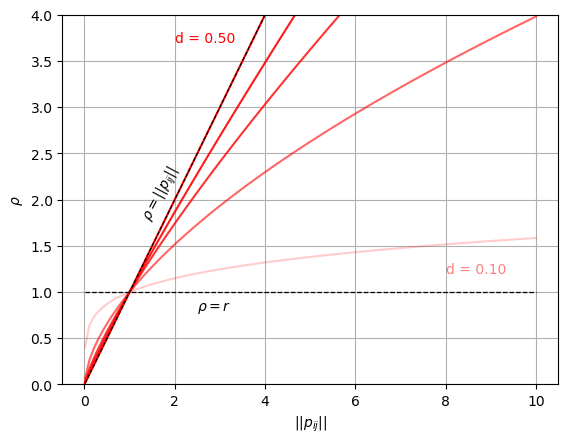

In [70]:
r = 1
d_list = [0.5, 0.45, 0.4, 0.3, 0.1]

# Rho equation
rho = lambda norm, d: r * ((norm**2)**(d)/r**(2*d))
#rho_neperian = lambda norm: r * (np.log(norm)**n2 + 1)**(1)

# Plot some rho functions candidates
norm = np.linspace(0.01, 10*r, 100)

for n in n_list:
    plt.plot(norm, rho(norm,n), "r", alpha=2*n)

plt.text(2, 3.7, "d = {0:.2f}".format(n_list[0]), c="r", alpha=1)
plt.text(8, 1.2, "d = {0:.2f}".format(n_list[-1]), c="r", alpha=0.5)
plt.text(1.2, 1.8, r"$\rho = ||p_{ij}||$", c="k", rotation=62)
plt.text(2.5, 0.8, r"$\rho = r$", c="k")

plt.xlabel(r"$||p_{ij}||$")
plt.ylabel(r"$\rho$")

plt.plot(norm, norm, "--k", lw=0.8)
plt.plot(norm, r*np.ones(100), "--k", lw=0.9)
plt.ylim([0,4])
plt.grid(True)

## Drawing the collision zone of the ellipse

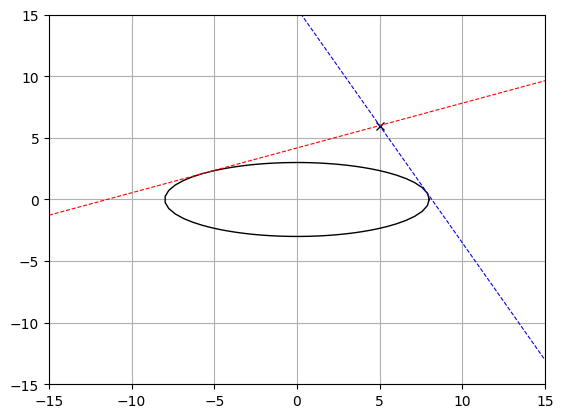

In [85]:
# Equation of the ellipse
a, b = 8, 3
r_ell = lambda t: a*b / np.sqrt((b*np.cos(t))**2 + (a*np.sin(t))**2) 

# Equation of tangent lines
y_tang1 = lambda x,m: m*x + np.sqrt(a**2*m**2 + b**2)
y_tang2 = lambda x,m: m*x - np.sqrt(a**2*m**2 + b**2)

# Compute m to find the tangent containing p
m1  = lambda x,y: (2*x*y + np.sqrt(4*x**2*y**2 - 4*(x**2 - a**2)*(y**2 - b**2)))/(2*(x**2 - a**2))
m2 = lambda x,y: (2*x*y - np.sqrt(4*x**2*y**2 - 4*(x**2 - a**2)*(y**2 - b**2)))/(2*(x**2 - a**2))

# Drawing ellipse and tangent lines to the point
x0, y0 = 5, 6 # robot position

t = np.linspace(0,2*np.pi,100)
r = r_ell(theta)

x = np.linspace(-15,15,100)

if y0 > 0:
    y1 = y_tang1(x,m1(x0,y0))
    y2 = y_tang1(x,m2(x0,y0))
elif y0 == 0 and x0 > 0:
    y1 = y_tang2(x,m1(x0,y0))
    y2 = y_tang1(x,m2(x0,y0))
elif y0 == 0 and x0 < 0:
    y1 = y_tang1(x,m1(x0,y0))
    y2 = y_tang2(x,m2(x0,y0))
else:
    y1 = y_tang2(x,m1(x0,y0))
    y2 = y_tang2(x,m2(x0,y0))

plt.plot(r*np.cos(t), r*np.sin(t), "-k", lw=1)
plt.plot(x0, y0, "xk")
plt.plot(x, y1, "--b", lw=0.8)
plt.plot(x, y2, "--r", lw=0.8)

plt.xlim([-15,15])
plt.ylim([-15,15])
plt.grid(True)
plt.show()

---
## Simulation 1

In [2]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 4, 4
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 80**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 1/60
t0 = 0
t_sim_final = 50

# Constantes de los controladores
ke = 0.2
kn = 2

r = 3
gamma = 4

# n = 2
# alfa = 1.4
# rho = lambda prel: alfa * r**(2*n+1)/(prel.T@prel)**(n)  
# rho_dot = lambda prel, vrel: - alfa * r**(2*n+1) * n*(prel.T@prel)**(n-1) * (2*prel.T@vrel)/(prel.T@prel)**(2*n)

n1 = 1/3
rho = lambda prel, k: r * ((prel.T@prel)**(n1)/r**(2*n1))
rho_dot = lambda prel, vrel, k: r * (n1*(prel.T@prel)**(n1-1) * prel.T@vrel/ r**(2*n1))

# Estado inicial de los agentes y número de agentes
n_agents = 8

# Alineados
pij_init = r*2
p0 = np.zeros((n_agents, 2))
p0[:,0] = - np.linspace(1.1*a, 1.1*a + pij_init*(n_agents-1), n_agents)

# Ordenados por velocidad
vi_slower = 0.2
vij = np.random.rand(n_agents-1)*5 + 0.2 # aleatoria
#vij = 0.2*np.ones(n_agents-1) # paso fijo

v0 = np.ones((n_agents,1)) * vi_slower 
for n in range(n_agents-1):
    v0[n+1] = v0[n] + vij[n]

v0 = v0

# Alineados en dirección
phi0 = np.ones(n_agents) * (np.pi/2)

# Generamos los vectores de estado iniciales
x0 = [t0, p0, v0, phi0]

In [452]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, t_cbf=20, rho=rho, rho_dot=rho_dot)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

preldata = []
omega = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    preldata.append(sim.p_rel)
    omega.append(sim.w)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

preldata = np.linalg.norm(np.array(preldata), axis=3)
omega = np.array(omega)

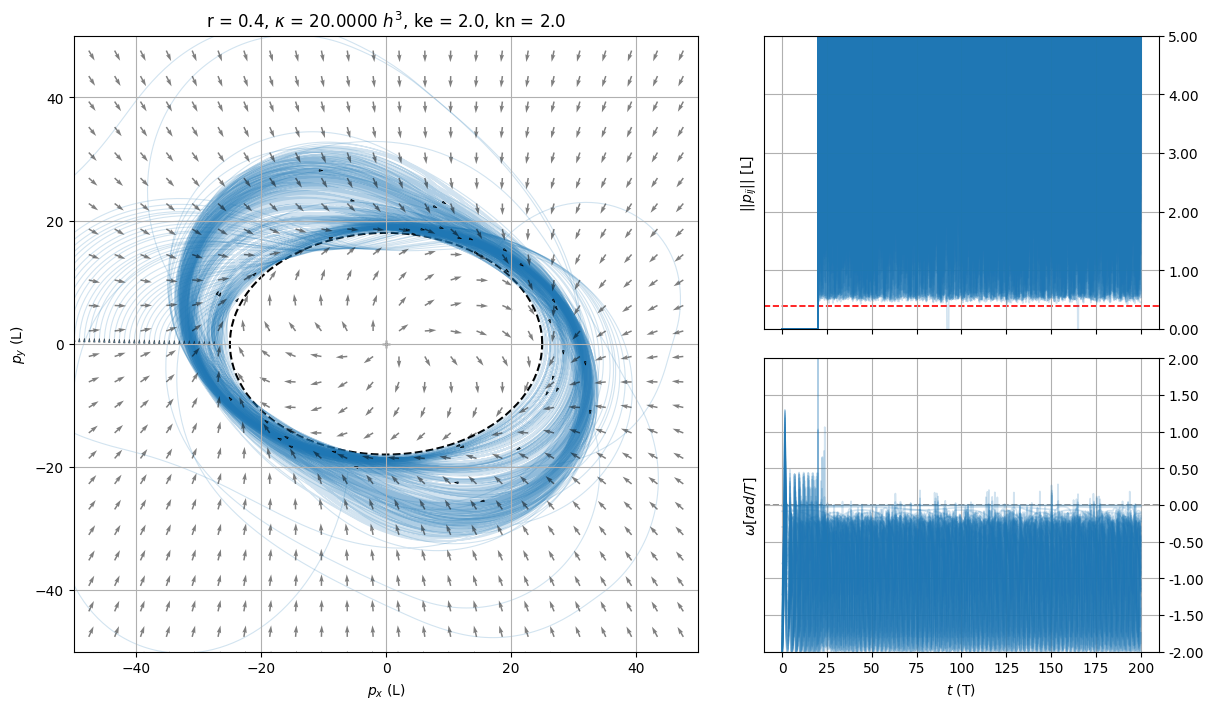

In [453]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-50,50])
main_ax.set_ylim([-50,50])
main_ax.set_ylabel(r"$p_y$ (L)")  
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title(r"r = {0:.1f}, $\kappa$ = {1:.4f} $h^3$, ke = {2:.1f}, kn = {3:.1f}".format(r, gamma, ke, kn))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[0]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color, size=0.5)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color, size=0.5)

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=0.8, zorder=0, alpha=0.2)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

plt.show()

In [70]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail = 50
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax      = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[0])
#  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
#  icon_init.set_alpha(0.6)
#  icon_init.set_label("n"+str(n))


#  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[0],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title(r"r = {0:.1f}, $\kappa$ = {1:.4f} $h^3$, ke = {2:.1f}, kn = {3:.1f}".format(r, gamma, ke, kn))

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

pline = prel_ax.axvline(0, c="black", ls="--", lw=1.2)
wline = wdata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[0])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  pline.set_xdata(i*dt)
  wline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=1/60*1000)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

C:\Users\Jesús\AppData\Local\Temp\ipykernel_33284\3090466023.py:6: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  9.98 | 9.99%
tf = 19.97 | 19.97%
tf = 29.95 | 29.96%
tf = 39.93 | 39.95%
tf = 49.92 | 49.93%
tf = 59.90 | 59.92%
tf = 69.88 | 69.91%
tf = 79.87 | 79.89%
tf = 89.85 | 89.88%
tf = 99.83 | 99.87%


## Simulation 2

In [89]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 20, 12
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 120**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 1/60
t0 = 0
t_sim_final = 50

# Constantes de los controladores
ke = 3
kn = 2

r = 0.3
gamma = 1

n1 = 1/4
rho = lambda prel, k: r * ((prel.T@prel)**(n1)/r**(2*n1))
rho_dot = lambda prel, vrel, k: r * (n1*(prel.T@prel)**(n1-1) * prel.T@vrel/ r**(2*n1))

# n2 = 1.1
# rho = lambda prel: r * np.log((prel.T@prel)**(1/2) + 1)**n2
# rho_dot = lambda prel, vrel: r * n2 * np.log((prel.T@prel)**(1/2) + 1)**(n2-1) * \
#                             (prel.T@vrel/(prel.T@prel)**(1/2)) / ((prel.T@prel)**(1/2) + 1) # ln(x)' = x'/x

# Number of agents
n_agents = 50

# Initial states
p0 = 2*(np.random.rand(n_agents, 2)-0.5) * 30
v0 = np.random.rand(n_agents,1) * 6 + 1
phi0 = 2*(np.random.rand(n_agents) - 0.5) * (np.pi)

# p0 = np.array(gvf_traj.param_points(pts=n_agents)).T*2
# t = s * gvf_traj.grad_phi(p0) @ E.T
# phi0 = np.arctan2(t[:,1],t[:,0]) + np.pi/4

# Generamos los vectores de estado iniciales
x0 = [t0, p0, v0, phi0]

In [90]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, t_cbf=5, rho=rho, rho_dot=rho_dot)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

preldata = []
omega = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    preldata.append(sim.p_rel)
    omega.append(sim.w)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

preldata = np.linalg.norm(np.array(preldata), axis=3)
omega = np.array(omega)

693


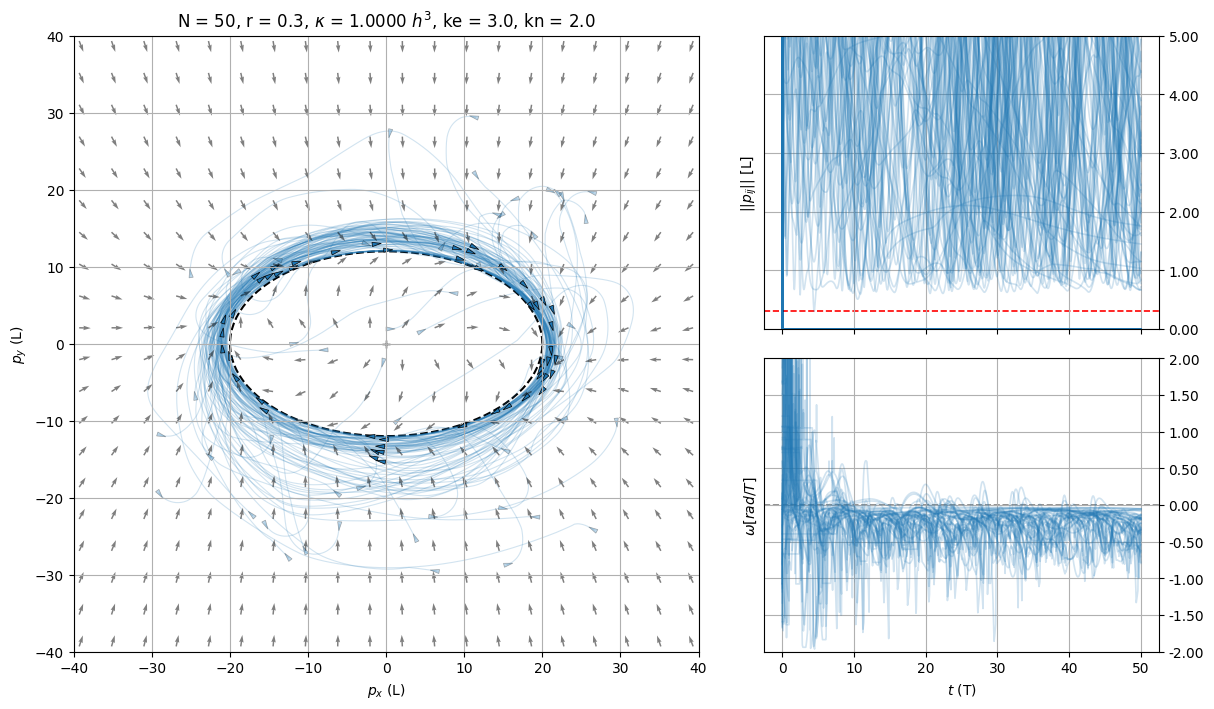

In [91]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-40,40])
main_ax.set_ylim([-40,40])
main_ax.set_ylabel(r"$p_y$ (L)")  
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title(r"N = {0:d}, r = {1:.1f}, $\kappa$ = {2:.4f} $h^3$, ke = {3:.1f}, kn = {4:.1f}".format(n_agents, r, gamma, ke, kn))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[0]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color, size=1)
  icon_init.set_alpha(0.3)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color, size=1)

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=0.8, zorder=0, alpha=0.2)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
count = 0
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

      if preldata[-1,n,k]<r:
              count = count + 1 

print(count)
plt.show()

In [479]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail = 50
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax      = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-30,30])
main_ax.set_ylim([-30,30])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[0])
#  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
#  icon_init.set_alpha(0.6)
#  icon_init.set_label("n"+str(n))


#  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[0],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title(r"N = {0:d}, r = {1:.1f}, $\kappa$ = {2:.4f} $h^3$, ke = {3:.1f}, kn = {4:.1f}".format(n_agents, r, gamma, ke, kn))

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(r, c="red", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.2)

pline = prel_ax.axvline(0, c="black", ls="--", lw=1.2)
wline = wdata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[0])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  pline.set_xdata(i*dt)
  wline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=1/60*1000)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  9.98 | 9.99%
tf = 19.97 | 19.97%


KeyboardInterrupt: 

## Simulation 3

In [15]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 20, 12
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 120**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 1/60
t0 = 0
t_sim_final = 100

# Constantes de los controladores
ke = 2
kn = 2

r = 0.5
gamma = 0.8

rc = 3
obs_list = [0,1]

n1 = 1/3
rho = lambda prel, k: r  * ((prel.T@prel)**(n1)/r**(2*n1))  * (k not in obs_list) + \
                      rc * ((prel.T@prel)**(n1)/rc**(2*n1)) * (k in obs_list)
rho_dot = lambda prel, vrel, k: r * (n1*(prel.T@prel)**(n1-1) * prel.T@vrel/ r**(2*n1))   * (k not in obs_list) + \
                                rc * (n1*(prel.T@prel)**(n1-1) * prel.T@vrel/ rc**(2*n1)) * (k in obs_list)

# Number of agents
n_agents = 102

# Initial states
p0 = 2*(np.random.rand(n_agents, 2)-0.5) * 30
v0 = np.random.rand(n_agents,1) * 6 + 4
phi0 = 2*(np.random.rand(n_agents) - 0.5) * (np.pi)

# Initial state of the obstacles
p0[0,:] = np.array([-20,-20])
p0[1,:] = np.array([-20,12])
v0[0] = 0.25
v0[1] = 3.9

phi0[0] = 0
t = -s*gvf_traj.grad_phi(p0[1,:][:,None].T)@E.T
phi0[1] = np.arctan2(t[0,1],t[0,0])

# Generamos los vectores de estado iniciales
x0 = [t0, p0, v0, phi0]

In [16]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, t_cbf=10, rho=rho, rho_dot=rho_dot, obs=obs_list)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

preldata = []
omega = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    preldata.append(sim.p_rel)
    omega.append(sim.w)

  # # Moving the obstacle
  # if gvf_traj.phi(sim.pf[0,:][:,None].T)>0:
  #   v0[0] = 0.25
  # else:
  #   v0[0] = 5

  # Simulator euler step integration
  t = -s*gvf_traj.grad_phi(sim.pf[1,:][:,None].T)@E.T
  sim.phif[1] = np.arctan2(t[0,1],t[0,0])
  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

preldata = np.linalg.norm(np.array(preldata), axis=3)
omega = np.array(omega)

KeyboardInterrupt: 

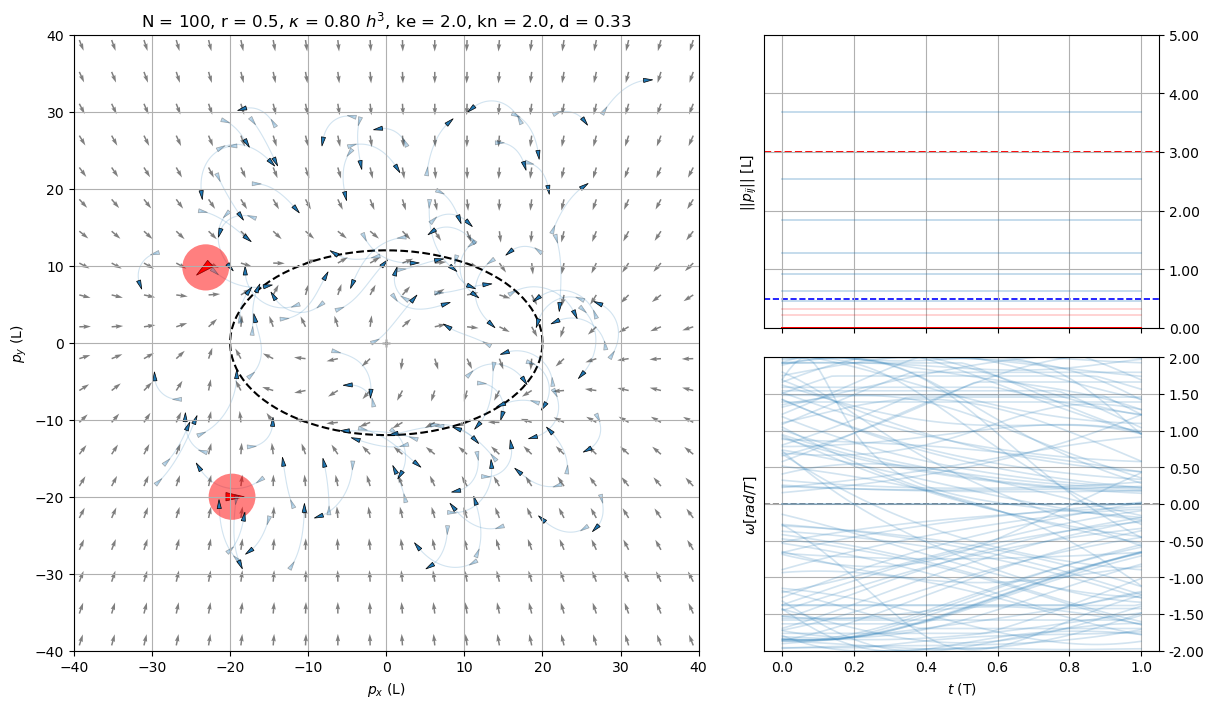

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-40,40])
main_ax.set_ylim([-40,40])
main_ax.set_ylabel(r"$p_y$ (L)")  
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title(r"N = {0:d}, r = {1:.1f}, $\kappa$ = {2:.2f} $h^3$, ke = {3:.1f}, kn = {4:.1f}, d = {5:.2f}".format(n_agents-len(obs_list), r, gamma, ke, kn, n1))

# Draw unicycle icons
li = xdata.shape[0] - 1
for n in range(sim.N):
  # Draw agents
  if n not in obs_list:
    color = color_palette()[0]
    icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color, size=1)
    icon_init.set_alpha(0.3)
    icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color, size=1)

    main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=0.8, zorder=0, alpha=0.2)
    main_ax.add_patch(icon_init)
    main_ax.add_patch(icon)

  # Draw moving static obstacle icon
  else: 
    icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], "r", size=2)
    icon_col = patches.Circle([xdata[li,n], ydata[li,n]], rc, alpha=0.5, fill=True,
                              color="r", ls="-", lw=0)
    main_ax.add_patch(icon)
    main_ax.add_patch(icon_col)
    

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(rc, c="r", ls="--", lw=1.4, zorder=0, alpha=1)
prel_ax.axhline(r,  c="b", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      if n in obs_list:
        if k not in obs_list:
          prel_ax.plot(time_vec, preldata[:,k,n], c="r", lw=1.2, alpha=0.2, zorder=3)
      else:
        prel_ax.plot(time_vec, preldata[:,k,n], c=color_palette()[0], lw=1.2, alpha=0.3, zorder=2)

plt.show()

In [159]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

tf_anim = t_sim_final
tf_anim = 60
n_tail = 50
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
prel_ax      = fig.add_subplot(grid[0, 3:5], xticklabels=[])
wdata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-40,40])
main_ax.set_ylim([-40,40])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(prel_ax, ylabel = r"$||p_{ij}||$ [L]", ylim=[0,5])
fmt_data_axis(wdata_ax, r"$\omega [rad/T]$", r"$t$ (T)", ylim=[-2,2])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
icons_col_plt = []

c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[0])

# Draw unicycle icons
for n in range(sim.N):
  # Draw agents
  if n not in obs_list:
    icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[0])
    line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[0], ls="-", lw=0.8)

    main_ax.add_patch(icon)
    lines_plt.append(line)
    icons_plt.append(icon)

  # Draw moving static obstacle icon
  else: 
    icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], "k", size=2)
    icon_col = patches.Circle([xdata[li,n], ydata[li,n]], rc, alpha=0.7, fill=True,
                          color="gray", ls="-", lw=0, zorder=4)

    line, = main_ax.plot(xdata[:,n], ydata[:,n], c="k", ls="-", lw=0)

    main_ax.add_patch(icon)
    main_ax.add_patch(icon_col)
    lines_plt.append(line)
    icons_plt.append(icon)
    icons_col_plt.append(icon_col)

txt_title = main_ax.set_title(r"N = {0:d}, r = {1:.1f}, $\kappa$ = {2:.2f} $h^3$, ke = {3:.1f}, kn = {4:.1f}, d = {5:.2f}".format(n_agents-len(obs_list), r, gamma, ke, kn, n1))

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
prel_ax.axhline(rc, c="k", ls="--", lw=1.4, zorder=1, alpha=1)
prel_ax.axhline(r,  c="b", ls="--", lw=1.2, zorder=0, alpha=1)
wdata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wdata_ax.plot(time_vec, omega[:,n], c=color_palette()[0], lw=1.2, alpha=0.2)
  for k in range(sim.N):
    if k > n:
      if n in obs_list:
        prel_ax.plot(time_vec, preldata[:,n,k], c="k", lw=1.2, alpha=0.3, zorder=3)
      else:
        prel_ax.plot(time_vec, preldata[:,n,k], c=color_palette()[0], lw=1.2, alpha=0.3, zorder=2)

pline = prel_ax.axvline(0, c="black", ls="--", lw=1.2)
wline = wdata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    if n not in obs_list:
      icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[0])
      icons_plt[n].set_zorder(3)

    else:
      icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], "k", size=2)
      icons_plt[n].set_zorder(3)

      n_ = np.where(np.array(obs_list) == n)[0][0]
      icons_col_plt[n_].set(center = [xdata[i,n], ydata[i,n]])

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  pline.set_xdata(i*dt)
  wline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=int(tf_anim/dt-1), interval=1/60*1000, blit=False)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  9.98 | 9.99%
tf = 19.97 | 19.97%
tf = 29.95 | 29.96%
tf = 39.93 | 39.95%
tf = 49.92 | 49.93%
tf = 59.90 | 59.92%
